# SECOND TASK CURZI ILARIA
# Meetups in dublin (2018)

This project analyzes the Meetup event network in Dublin (2018), based on data collected through the Meetup.com API.
Each node represents a single event, and edges connect events that share participants.

Edge weights reflect the normalized number of shared users. To reduce noise and focus on meaningful connections, we applied a threshold of 0.05: only edges with weight above this value are kept.

After filtering, we treated the network as unweighted, ignoring edge weights in the rest of the analysis

To better understand the structure and behavior of this network, we compare it with several theoretical models and tools introduced in class:

Generative models: Erdős–Rényi (ER), Watts–Strogatz (WS), and Barabási–Albert (BA)

Configuration model: keeps the same degree distribution, but rewires links randomly

Partition model: generates artificial networks with predefined community structure

Community detection & modularity: used to evaluate how strongly the network is organized into groups

Degree distribution: to analyze the variation in connectivity among nodes

Diffusion simulation (SI model): to explore how information might spread through the network structure (this analysis was added beyond the slides for further insight)

Each section explores which aspects of the real-world network can be explained by structural features (like degree, clustering, or community patterns) and which go beyond what these models can simulate.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Path to your edge list file inside Google Drive
network_path = "/content/drive/MyDrive/meetup-normalised-comembership.edges"

## Visual exploration of network models

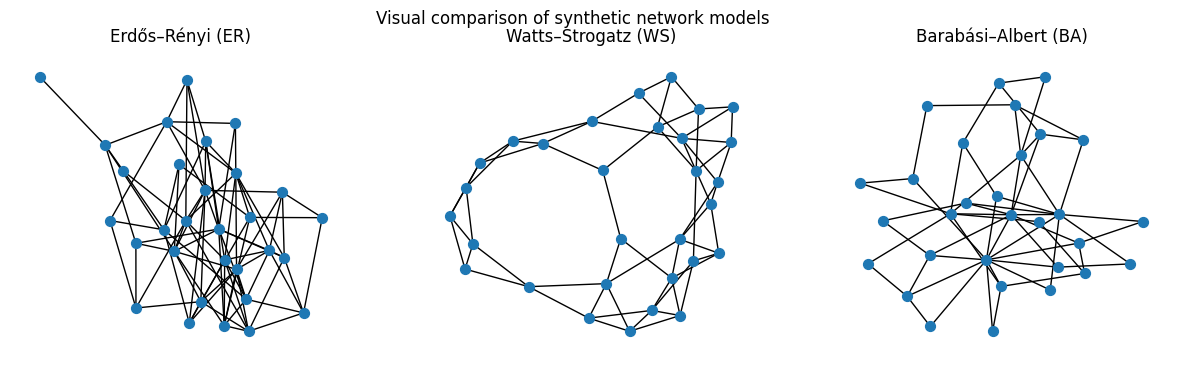

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Small networks to visualize structure
G_er_small = nx.gnp_random_graph(30, 0.2, seed=1)
G_ws_small = nx.watts_strogatz_graph(30, 4, 0.3, seed=2)
G_ba_small = nx.barabasi_albert_graph(30, 2, seed=3)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

nx.draw(G_er_small, ax=axes[0], node_size=50, with_labels=False)
axes[0].set_title("Erdős–Rényi (ER)")

nx.draw(G_ws_small, ax=axes[1], node_size=50, with_labels=False)
axes[1].set_title("Watts–Strogatz (WS)")

nx.draw(G_ba_small, ax=axes[2], node_size=50, with_labels=False)
axes[2].set_title("Barabási–Albert (BA)")

plt.suptitle("Visual comparison of synthetic network models")
plt.show()


In [5]:
def summarize_graph(G, name):
    import numpy as np
    import networkx as nx

    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    clustering = nx.average_clustering(G)
    try:
        path_length = nx.average_shortest_path_length(G)
    except:
        path_length = float('inf')  # Graph is not connected
    print(f"--- {name} ---")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"Avg Degree: {avg_degree:.2f}")
    print(f"Clustering: {clustering:.4f}")
    print(f"Avg Path Length: {path_length if path_length != float('inf') else 'Not connected'}\n")
    return avg_degree, clustering, path_length

summarize_graph(G_er_small, "Small ER")
summarize_graph(G_ws_small, "Small WS")
summarize_graph(G_ba_small, "Small BA")


--- Small ER ---
Nodes: 30, Edges: 86
Avg Degree: 5.73
Clustering: 0.1726
Avg Path Length: 2.1241379310344826

--- Small WS ---
Nodes: 30, Edges: 60
Avg Degree: 4.00
Clustering: 0.3567
Avg Path Length: 3.0091954022988507

--- Small BA ---
Nodes: 30, Edges: 56
Avg Degree: 3.73
Clustering: 0.1971
Avg Path Length: 2.4689655172413794



(np.float64(3.7333333333333334), 0.19705868205868207, 2.4689655172413794)

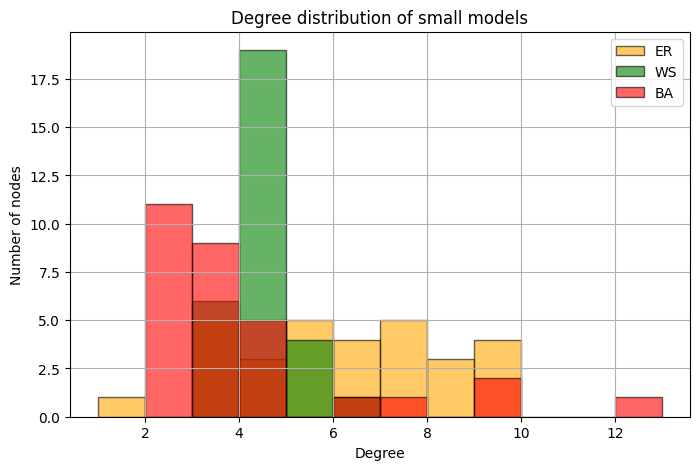

In [6]:
def plot_degree_distribution(G, label, color):
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=range(min(degrees), max(degrees)+2), alpha=0.6, label=label, color=color, edgecolor='black')


plt.figure(figsize=(8, 5))
plot_degree_distribution(G_er_small, "ER", "orange")
plot_degree_distribution(G_ws_small, "WS", "green")
plot_degree_distribution(G_ba_small, "BA", "red")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("Degree distribution of small models")
plt.grid(True)
plt.show()


ER has a wide range of degrees due to random connections.

WS shows most nodes with the same degree, because of its regular structure.

BA has many low-degree nodes and a few with higher degrees, showing the beginning of a hub structure.

## Comparison Between my Network and Generative Models

We now compare this real network with three classical models (ER, WS, BA) to see which ones better match its properties.

### Structural Metrics: Real vs Models

In [17]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt


def read_weighted_edgelist(in_path):
    g = nx.Graph()
    with open(in_path, "r") as fin:
        for line in fin:
            node1, node2, weight = line.strip().split(" ")
            g.add_edge(int(node1), int(node2), weight=float(weight))
    return g


G = read_weighted_edgelist(network_path)

# Filter the graph by edge weight (threshold = 0.05)
weight_threshold = 0.05
G_filtered = nx.Graph(
    (u, v, d) for u, v, d in G.edges(data=True) if d["weight"] > weight_threshold
)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# Comparison functions
def plot_degree_distribution(G, label, color):
    degrees = [d for n, d in G.degree()]
    plt.hist(degrees, bins=50, alpha=0.6, label=label, color=color)

def summarize_graph(G, name):
    degrees = [d for n, d in G.degree()]
    avg_degree = np.mean(degrees)
    clustering = nx.average_clustering(G)
    try:
        path_length = nx.average_shortest_path_length(G)
    except:
        path_length = float('inf')  # Graph is not connected
    print(f"--- {name} ---")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    print(f"Avg Degree: {avg_degree:.2f}")
    print(f"Clustering: {clustering:.4f}")
    print(f"Avg Path Length: {path_length if path_length != float('inf') else 'Not connected'}\n")
    return avg_degree, clustering, path_length

# 1. My real network
G_real = G_filtered.copy()

# 2. ER network with same number of nodes and approximate density
N = G_real.number_of_nodes()
E = G_real.number_of_edges()
p = 2 * E / (N * (N - 1))  # approximate density
G_er = nx.gnp_random_graph(N, p)

# 3. WS network: high clustering + short path length
k = int(np.mean([d for n, d in G_real.degree()]))
G_ws = nx.watts_strogatz_graph(N, k, 0.1)

# 4. BA network: few hubs + power-law distribution
m = k // 2 if k >= 2 else 1
G_ba = nx.barabasi_albert_graph(N, m)

# Statistics
summarize_graph(G_real, "Real Meetup Network")
summarize_graph(G_er, "Erdős-Rényi (Random)")
summarize_graph(G_ws, "Watts-Strogatz (Small-World)")
summarize_graph(G_ba, "Barabási-Albert (Scale-Free)")



--- Real Meetup Network ---
Nodes: 1121, Edges: 6728
Avg Degree: 12.00
Clustering: 0.3600
Avg Path Length: Not connected

--- Erdős-Rényi (Random) ---
Nodes: 1121, Edges: 6704
Avg Degree: 11.96
Clustering: 0.0105
Avg Path Length: 3.092312348668281

--- Watts-Strogatz (Small-World) ---
Nodes: 1121, Edges: 6726
Avg Degree: 12.00
Clustering: 0.4995
Avg Path Length: 4.09043264942016

--- Barabási-Albert (Scale-Free) ---
Nodes: 1121, Edges: 6690
Avg Degree: 11.94
Clustering: 0.0389
Avg Path Length: 2.8742098891296037



(np.float64(11.935771632471008), 0.03887449346730583, 2.8742098891296037)

The real Meetup network has 1,121 nodes, 6,728 edges, and high clustering (0.36), meaning that many events form local groups. It is not fully connected.

The Erdős–Rényi model has similar size but very low clustering (0.01) and no clear groups.

The Watts–Strogatz model shows very high clustering (0.50), but longer paths. It simulates local structure well but overestimates connections.

The Barabási–Albert model creates short paths (2.87) with hubs, but low clustering (0.04), so no real communities.

We conclude that no model matches the real network perfectly. Each one captures only part of its structure.

### Degree Distribution: Real vs Models

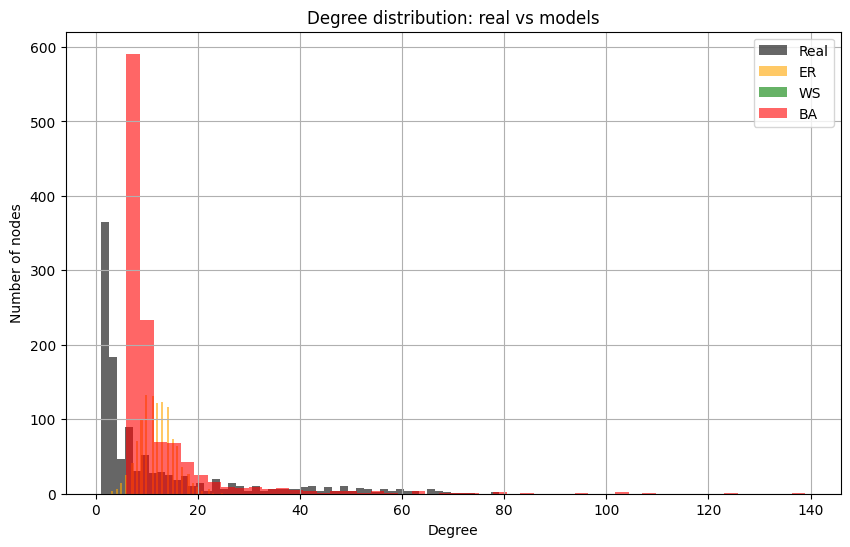

In [ ]:
plt.figure(figsize=(10, 6))

plot_degree_distribution(G_real, label="Real", color="black")
plot_degree_distribution(G_er, label="ER", color="orange")
plot_degree_distribution(G_ws, label="WS", color="green")
plot_degree_distribution(G_ba, label="BA", color="red")

plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree distribution: real vs models")
plt.legend()
plt.grid(True)
plt.show()


This plot shows how node connectivity (degree) is distributed in the real Meetup network and in the synthetic models.

The real network has a broad distribution, with many nodes of low degree and a few highly connected ones (long tail).

The ER and WS models have more narrow, symmetric distributions — most nodes have similar degrees.

The BA model captures the long tail better, with many low-degree nodes and some hubs — similar to the real network, but even more extreme.

We can conclude that only the Barabási–Albert model reproduces the heavy-tailed shape seen in the real data. ER and WS models underestimate heterogeneity in connectivity.

## Partition model

We test whether the real Meetup network has a stronger or weaker community structure compared to an artificial network generated using the Planted Partition Model, which has predefined communities.

<ipython-input-11-d4f2bcc35e8a>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Set1', len(blocks))


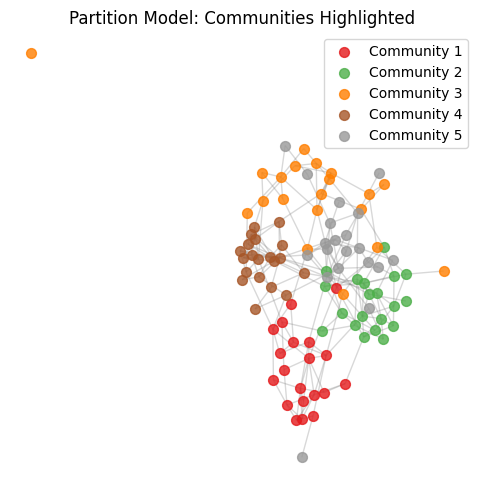

In [11]:
import matplotlib.cm as cm
import numpy as np

# Get community membership (list of lists of nodes)
blocks = [list(range(i * 20, (i + 1) * 20)) for i in range(5)]
colors = cm.get_cmap('Set1', len(blocks))

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G_example, seed=2)

for i, block in enumerate(blocks):
    nx.draw_networkx_nodes(G_example, pos,
                           nodelist=block,
                           node_color=[colors(i)],
                           label=f"Community {i+1}",
                           node_size=50,
                           alpha=0.8)
nx.draw_networkx_edges(G_example, pos, alpha=0.3, edge_color='gray')
plt.title("Partition Model: Communities Highlighted")
plt.axis('off')
plt.legend()
plt.show()




This is a simplified example for illustration purposes.
In the next step, we will create a larger partition model with parameters that better reflect the size and density of the real Meetup network.

In [ ]:
# Parameters: 8 communities of 150 nodes each (total ~1200, similar to my network)
n_communities = 8
size = 140
p_in = 0.1
p_out = 0.005

G_partition = nx.planted_partition_graph(l=n_communities, k=size, p_in=p_in, p_out=p_out, seed=42)


In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

# Real network
communities_real = list(greedy_modularity_communities(G_filtered))
modularity_real = nx.algorithms.community.quality.modularity(G_filtered, communities_real)

# Simulated partition model
communities_sim = list(greedy_modularity_communities(G_partition))
modularity_sim = nx.algorithms.community.quality.modularity(G_partition, communities_sim)

print(f"Real network: {len(communities_real)} communities, modularity = {modularity_real:.4f}")
print(f"Partition model: {len(communities_sim)} communities, modularity = {modularity_sim:.4f}")



Real network: 86 communities, modularity = 0.6092
Partition model: 7 communities, modularity = 0.5754


To analyze the community structure of the Meetup network, it was compared with an artificial network created using the Partition Model, designed to have 8 predefined communities.

The real network showed 86 communities with a high modularity of 0.609, which means it has a strong and non-random community structure.

The simulated network showed 7 communities, with a modularity of 0.575, confirming that nodes are well connected inside each community, but less connected between communities.

We conclude that the real Meetup network has a more complex and fragmented community structure than the artificial model. This suggests that co-participation in events in Dublin naturally creates diverse thematic clusters.

## Configuration model

To check whether the structure of the Meetup network can be explained solely by its degree distribution, we create a configuration model.
This model keeps the same degree for each node as in the real network, but randomly rewires the edges, removing any underlying community or clustering structure.

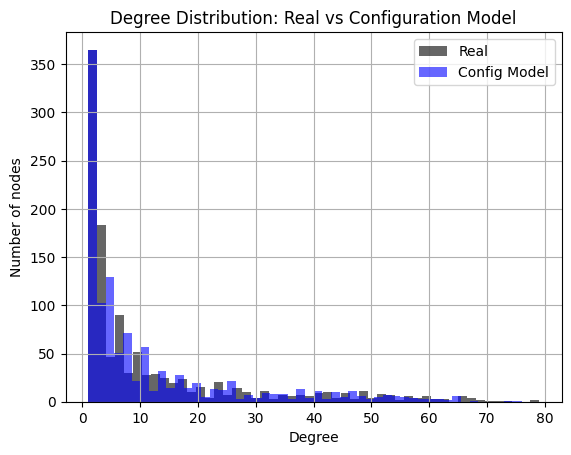

In [18]:
# Degree distribution of the real network
real_degrees = [d for n, d in G_filtered.degree()]
plt.hist(real_degrees, bins=50, alpha=0.6, label="Real", color='black')

# Step 2 — Build the configuration model
degree_sequence = real_degrees
G_config_raw = nx.configuration_model(degree_sequence, seed=42)

# Convert to a simple undirected graph (remove multi-edges and self-loops)
G_config = nx.Graph(G_config_raw)
G_config.remove_edges_from(nx.selfloop_edges(G_config))

# Degree distribution of the configuration model
config_degrees = [d for n, d in G_config.degree()]
plt.hist(config_degrees, bins=50, alpha=0.6, label="Config Model", color='blue')

plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.title("Degree Distribution: Real vs Configuration Model")
plt.legend()
plt.grid(True)
plt.show()


As expected, the two distributions are almost identical, since the Configuration Model was built to preserve the degree sequence of the real network. This confirms that the number of connections per node is maintained in both.

However, as shown in later analyses, this structural similarity does not translate into similar community organization or clustering—highlighting that degree alone is not enough to capture the real network’s complexity.

In [ ]:
# Get the degree sequence from the real network
degree_sequence = [d for n, d in G_filtered.degree()]

# Build the configuration model
G_config_raw = nx.configuration_model(degree_sequence, seed=42)

# Convert to a simple undirected graph (removing self-loops and multi-edges)
G_config = nx.Graph(G_config_raw)  # removes multi-edges
G_config.remove_edges_from(nx.selfloop_edges(G_config))  # removes self-loops



In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

# Communities in the configuration model
communities_config = list(greedy_modularity_communities(G_config))
modularity_config = modularity(G_config, communities_config)

# Communities in the real network (for comparison)
communities_real = list(greedy_modularity_communities(G_filtered))
modularity_real = modularity(G_filtered, communities_real)

print(f"Real network: {len(communities_real)} communities, modularity = {modularity_real:.4f}")
print(f"Configuration model: {len(communities_config)} communities, modularity = {modularity_config:.4f}")



Real network: 86 communities, modularity = 0.6092
Configuration model: 11 communities, modularity = 0.2295


In [ ]:
clustering_real = nx.average_clustering(G_filtered)
clustering_config = nx.average_clustering(G_config)

print(f"Real network clustering: {clustering_real:.4f}")
print(f"Configuration model clustering: {clustering_config:.4f}")


Real network clustering: 0.3600
Configuration model clustering: 0.0516


The real network showed 86 communities, high modularity (0.609), and average clustering of 0.360.

The configuration model, with the same degree distribution, showed only 11 communities, low modularity (0.229), and very low clustering (0.0516).

We conclude that the degree distribution alone is not enough to explain the complexity of the real network. The links between events are likely influenced by thematic similarity, selective co-participation, or social mechanisms.

## 1. Simulate an information spread on all networks (real + models)
We now simulate a simple diffusion process (SI model) to compare how information spreads in the real network and in the generated models. This helps reveal which structure allows faster and broader diffusion, and whether the real Meetup network supports or limits the spread of ideas across groups.

In [ ]:
import networkx as nx
import random
import matplotlib.pyplot as plt

def simulate_SI(G, beta=0.1, steps=30, seed=None):
    if seed: random.seed(seed)

    nodes = list(G.nodes())
    infected = set([random.choice(nodes)])
    infected_over_time = [len(infected)]

    for _ in range(steps):
        new_infected = set(infected)
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor not in infected and random.random() < beta:
                    new_infected.add(neighbor)
        infected = new_infected
        infected_over_time.append(len(infected))

    return infected_over_time


In [ ]:
# Parameters
N = G_filtered.number_of_nodes()
E = G_filtered.number_of_edges()
k = int(sum(dict(G_filtered.degree()).values()) / N)
p = 2 * E / (N * (N - 1))
m = max(1, k // 2)

# ER
G_er = nx.gnp_random_graph(N, p)
# WS
G_ws = nx.watts_strogatz_graph(N, k, 0.1)
# BA
G_ba = nx.barabasi_albert_graph(N, m)


In [ ]:
# Diffusion with beta = 0.05 for 30 step
beta = 0.05
steps = 30

infected_real = simulate_SI(G_filtered, beta, steps, seed=42)
infected_er   = simulate_SI(G_er, beta, steps, seed=42)
infected_ws   = simulate_SI(G_ws, beta, steps, seed=42)
infected_ba   = simulate_SI(G_ba, beta, steps, seed=42)


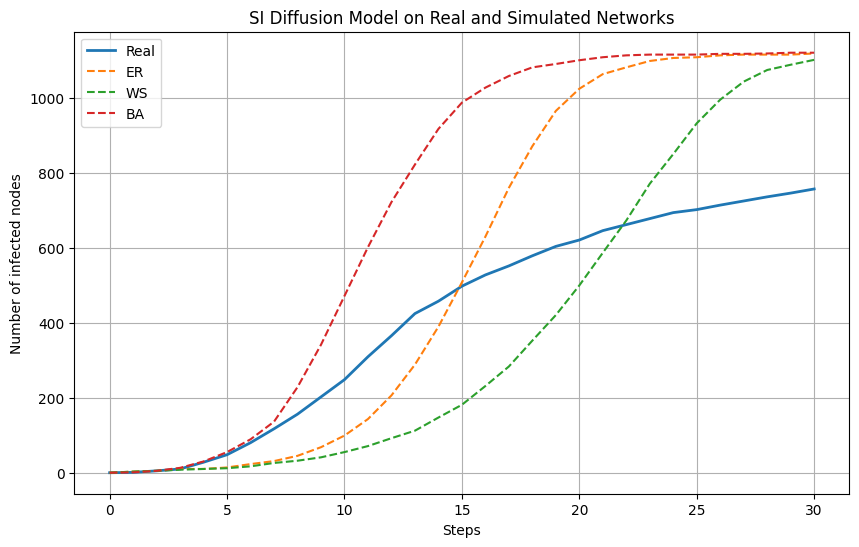

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(infected_real, label="Real", linewidth=2)
plt.plot(infected_er,   label="ER", linestyle="--")
plt.plot(infected_ws,   label="WS", linestyle="--")
plt.plot(infected_ba,   label="BA", linestyle="--")
plt.xlabel("Steps")
plt.ylabel("Number of infected nodes")
plt.title("SI Diffusion Model on Real and Simulated Networks")
plt.legend()
plt.grid(True)
plt.show()


The chart shows how information spreads (SI model) in the real Meetup network and in three theoretical models: Erdős–Rényi (ER), Watts–Strogatz (WS), and Barabási–Albert (BA).

The BA model spreads fastest due to highly connected hubs.
ER spreads quickly too, but slightly slower.
WS spreads more slowly because of its high clustering and local links.
The real network spreads gradually—slower than ER and BA, but faster than WS—suggesting some bridge events connect different groups.

We conclude that the real Meetup network does not support viral spread. Instead, it allows gradual diffusion through socially connected subgroups

We can conclude that the real Meetup network is shaped by how people behave socially, choosing events with similar topics and often joining the same kinds of groups. This creates a structure that is not random and cannot be fully explained by basic models.